# **Data Processing**

## Notebook Setup

First, import all necessary packages

In [ ]:
!pip install pymannkendall xarray cfgrib contextily cartopy

In [2]:
import ee
import geemap
import geemap.colormaps as cm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import math
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.sparse import diags, eye
from scipy.sparse.linalg import spsolve
from scipy.signal import savgol_filter
import pymannkendall as mk
import json
import os
from tqdm.notebook import tqdm
import geopandas as gpd
from glob import glob
from shapely.geometry import shape
from matplotlib.colors import TwoSlopeNorm
import contextily as cx  # for adding basemaps
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize
from matplotlib import cm
from shapely.geometry import shape, mapping
import xarray as xr

Set user defined variables

In [ ]:
setup_path = '/content/drive/MyDrive/final_project_code/src/analysis_setup.txt'

config = {}

with open(setup_path, 'r') as f:

    for line in f:
        line = line.strip()
        if not line or line.startswith('#'):
            continue
        key, value = line.split('=', 1)
        key = key.strip()
        value = value.strip().strip("'").strip('"')
        config[key] = value

# Convert known integers
config['start_year'] = int(config['start_year'])
config['end_year'] = int(config['end_year'])

# Create the variables from the config dictionary
ee_username = config['ee_username']
study_area = config['study_area']
start_date = config['start_date']
end_date = config['end_date']
start_year = config['start_year']
end_year = config['end_year']
raw_pixel_evi_data = config['raw_pixel_evi_data']
processed_pixel_evi_data = config['processed_pixel_evi_data']
greening_strip = config['greening_strip']
kg_zones = config['kg_zones']
correlation_data = config['correlation_data']
geo_tiff_data = config['geo_tiff_data']

# Print them for reference and verification
print(ee_username, type(ee_username))
print(study_area, type(study_area))
print(start_date, type(start_date))
print(end_date, type(end_date))
print(start_year, type(start_year))
print(end_year, type(end_year))
print(raw_pixel_evi_data, type(raw_pixel_evi_data))
print(processed_pixel_evi_data, type(processed_pixel_evi_data))
print(greening_strip, type(greening_strip))
print(kg_zones, type(kg_zones))
print(correlation_data, type(correlation_data))
print(geo_tiff_data, type(geo_tiff_data))

ee-pantonopoulos517 <class 'str'>
projects/ee-pantonopoulos517/assets/Peru_Chile_ROI-2 <class 'str'>
2000-01-01 <class 'str'>
2024-12-31 <class 'str'>
2000 <class 'int'>
2024 <class 'int'>
/content/drive/MyDrive/final_raw_data <class 'str'>
/content/drive/MyDrive/final_processed_data <class 'str'>
projects/ee-pantonopoulos517/assets/final_greening_strip <class 'str'>
projects/ee-pantonopoulos517/assets/koppen_geiger_0p00833333 <class 'str'>
/content/drive/MyDrive/correlation_data <class 'str'>
/content/drive/MyDrive/geo_tiff_data <class 'str'>


Initialise Google Earth Engine

In [12]:
try:
    ee.Initialize(project=ee_username)
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project=ee_username)

## Data Processing Pipeline

Now we need to process all pixels in each tile. The analysis pipeline in the key paper (DOI 10.3390/rs15143628) was followed. Save the change in EVI ( Δ𝐸𝑉𝐼 ) for each pixel (along with its coordinates) to file

In [ ]:
input_dir = raw_pixel_evi_data
output_dir = processed_pixel_evi_data
os.makedirs(output_dir, exist_ok=True)

Analysis below

In [ ]:
def whittaker_smooth(y, lmbd=10):
    """
    Apply Whittaker smoothing to a 1D time series with optional NaN handling.

    Whittaker smoothing is a penalised least squares approach that balances 
    fidelity to the input data with smoothness by minimising the second-order 
    differences. This implementation also handles missing (NaN) values by 
    applying weights only to observed entries.

    Parameters:
        y (array-like): 
            1D array or list of time series values (can include NaNs).
        lmbd (float, default=10): 
            Smoothing parameter. Higher values increase smoothness by penalising 
            curvature more heavily.

    Returns:
        np.ndarray: 
            Smoothed version of the input series, same shape as `y`.
    """

    y = np.asarray(y)
    n = len(y)
    E = eye(n, format='csc')
    D = E[1:] - E[:-1]  # first order difference matrix
    D2 = D[1:] - D[:-1]  # second order difference matrix
    W = diags((~np.isnan(y)).astype(int), 0, shape=(n, n), format='csc')  # weight matrix
    z = np.copy(y)
    z[np.isnan(z)] = 0  # fill NaNs 
    A = W + lmbd * D2.T @ D2
    B = W @ z

    return spsolve(A, B)

def process_tile_csv_method(file_path, frequency=23):
    """
    Process per-pixel EVI time series data from a CSV file, applying quality filtering,
    deseasonalisation, smoothing, trend analysis, and extracting statistically significant
    trends as GeoJSON-like features.

    Parameters:
        file_path (str): Path to the CSV file containing EVI and QA columns per pixel.
            Expected format: columns for EVI values labeled with '_EVI_' and QA flags
            labeled with '_QA_', plus a '.geo' column with pixel coordinates.
        frequency (int, optional): Seasonal decomposition period in number of observations.
            Default is 23, corresponding approximately to annual seasonality for 16-day MODIS composites.

    Returns:
        list of dict: List of features as dictionaries with 'geometry' (GeoJSON Point)
            and 'properties' containing the computed 'delta_evi' trend metric for each pixel
            that passes filtering and trend significance tests.
    """
    df = pd.read_csv(file_path)

    df = df.drop(columns=["system:index"], errors='ignore')

    evi_cols = sorted([col for col in df.columns if "_EVI_" in col]) # create a sorted list of all EVI column names 
    qa_cols = sorted([col for col in df.columns if "_QA_" in col]) # create a sorted list of all QA column names 

    evi_dates = [col.split("_EVI_")[-1] for col in evi_cols] # get the date from each EVI column
    qa_dates = [col.split("_QA_")[-1] for col in qa_cols] # get the date from each QA column
    if evi_dates != qa_dates:
        raise ValueError("EVI and QA columns not aligned.")

    time_index = pd.to_datetime(evi_dates, format="%Y%m%d")
    period_index = pd.PeriodIndex(time_index, freq="16D")

    features = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        try:
            evi_vals = row[evi_cols].astype(float).values * 0.0001 # scale EVI values
            qa_vals = row[qa_cols].astype(int).values
            ts = pd.Series(evi_vals, index=period_index)

            if ts.isna().mean() > 0.293: # exclude pixels with >29.3% missing data
                continue

            ts_interp = ts.interpolate(method='linear', limit_direction='both') # interpolate to remove consecutive NaNs before seasonal decomposition
            decomposition = seasonal_decompose(ts_interp, model='additive', period=frequency)
            deseasonalised = decomposition.trend + decomposition.resid # keep trend and residual components
            deseasonalised = deseasonalised.dropna() 

            qa_series = pd.Series(qa_vals, index=period_index)
            qa_vals_truncated = qa_series.loc[deseasonalised.index].values # don't want the values associated with NaNs
            invalid_mask = np.isin(qa_vals_truncated, [-1, 2, 3]) # Mask missing, snow/ice, clouds
            deseasonalised.iloc[invalid_mask] = np.nan

            if deseasonalised.isna().mean() > 0.293: # exclude pixels with >29.3% invalid data
                continue

            evi_cleaned = deseasonalised.interpolate(method='linear', limit_direction='both') # interpolate over missing values, snow/ice, clouds
            evi_smoothed = whittaker_smooth(evi_cleaned.values, lmbd=10) # first whittaker smooth (Ntr)
            evi_max_series = np.maximum(evi_cleaned.values, evi_smoothed) # N1

            d = np.abs(evi_cleaned.values - evi_smoothed)
            d_max = np.max(d)
            W = np.where(evi_cleaned.values >= evi_smoothed, 1.0, 1.0 - (d / d_max)) # fitting weights

            F_before = np.sum(np.abs(evi_max_series - evi_cleaned.values) * W) # initialise fitting index

            best_evi_max_series = evi_max_series.copy()
            num_iter = 0
            max_iter = 10
            fit = True

            while fit:
                
                if len(evi_max_series) >= 9: # length has to be greater than the window length 
                    evi_sav_gol = savgol_filter(evi_max_series, window_length=9, polyorder=6) # apply Savitzky-Golay smoothing

                else:
                    evi_sav_gol = evi_max_series.copy()

                # Update max envelope with new smooth fit, Nk
                evi_max_series = np.maximum(evi_cleaned.values, evi_sav_gol)

                # Compute new fitting index, Fk
                F_now = np.sum(np.abs(evi_max_series - evi_cleaned.values) * W)
                
                # Check for convergence or max iterations
                if F_now >= F_before or num_iter >= max_iter:

                    evi_max_series = best_evi_max_series # Use the last best version before it started getting worse
                    fit = False

                else:
                    # Store best fit and continue
                    best_evi_max_series = evi_max_series.copy()
                    F_before = F_now
                    num_iter += 1

            final_smoothed = whittaker_smooth(evi_max_series, lmbd=2) # final whittaker smooth

            mk_result = mk.original_test(final_smoothed) # mann-kendall test
            slope = mk_result.slope
            intercept = mk_result.intercept
            tau = mk_result.Tau
            p_value = mk_result.p

            if np.abs(tau) < 0.2 or p_value > 0.05: # check for statistical insignificance 
                continue

            delta_evi = 100 * slope * (len(ts_interp) - 1) / (intercept - slope * len(final_smoothed))

            if not (-200 < delta_evi < 200): # remove outliers
                continue

            # get geographical location
            geo_json = json.loads(row[".geo"])
            lon, lat = geo_json["coordinates"]

            features.append({
                "geometry": {"type": "Point", "coordinates": [lon, lat]},
                "properties": {"delta_evi": delta_evi}
            })

        except Exception as e:
            continue

    return features

Process and save features from each tile to .json file

In [ ]:
def process_and_save_features(file_path, output_dir, frequency=23):
    """
    Process a MODIS tile CSV file to extract EVI trend features and save them as a JSON file.

    Parameters:
        file_path (str): Path to the input CSV file containing EVI and QA data for a tile.
        output_dir (str): Directory where the output JSON file with extracted features will be saved.
        frequency (int, optional): Seasonal decomposition period (number of observations per cycle).
            Default is 23 (typical for annual seasonality with 16-day MODIS data).
    """

    tile_id = os.path.splitext(os.path.basename(file_path))[0]
    output_file = os.path.join(output_dir, f"{tile_id}_features.json")

    if os.path.exists(output_file):
        print(f"Skipping {tile_id}, already processed.") # so we can pick up where we left off if we stop the processing at any time
        return

    features = process_tile_csv_method(file_path, frequency)

    if features:
        with open(output_file, "w") as f:
            json.dump(features, f)

Process and save the tile's features

In [ ]:
csv_files = [f for f in os.listdir(input_dir) if f.endswith(".csv")]
print(csv_files) # for reference
for csv_file in tqdm(csv_files):
    full_path = os.path.join(input_dir, csv_file)
    process_and_save_features(full_path, output_dir)

Now we want to plot the Δ𝐸𝑉𝐼 heatmap over a satellite image of the ROI, use matplotlib for this

In [13]:
# Load features
json_files = glob(processed_pixel_evi_data+"/*.json")
all_features = []

for f in json_files:
    with open(f, 'r') as file:
        data = json.load(file)
        for feat in data:
            geom = shape(feat['geometry'])
            props = feat['properties']
            props['geometry'] = geom
            all_features.append(props)

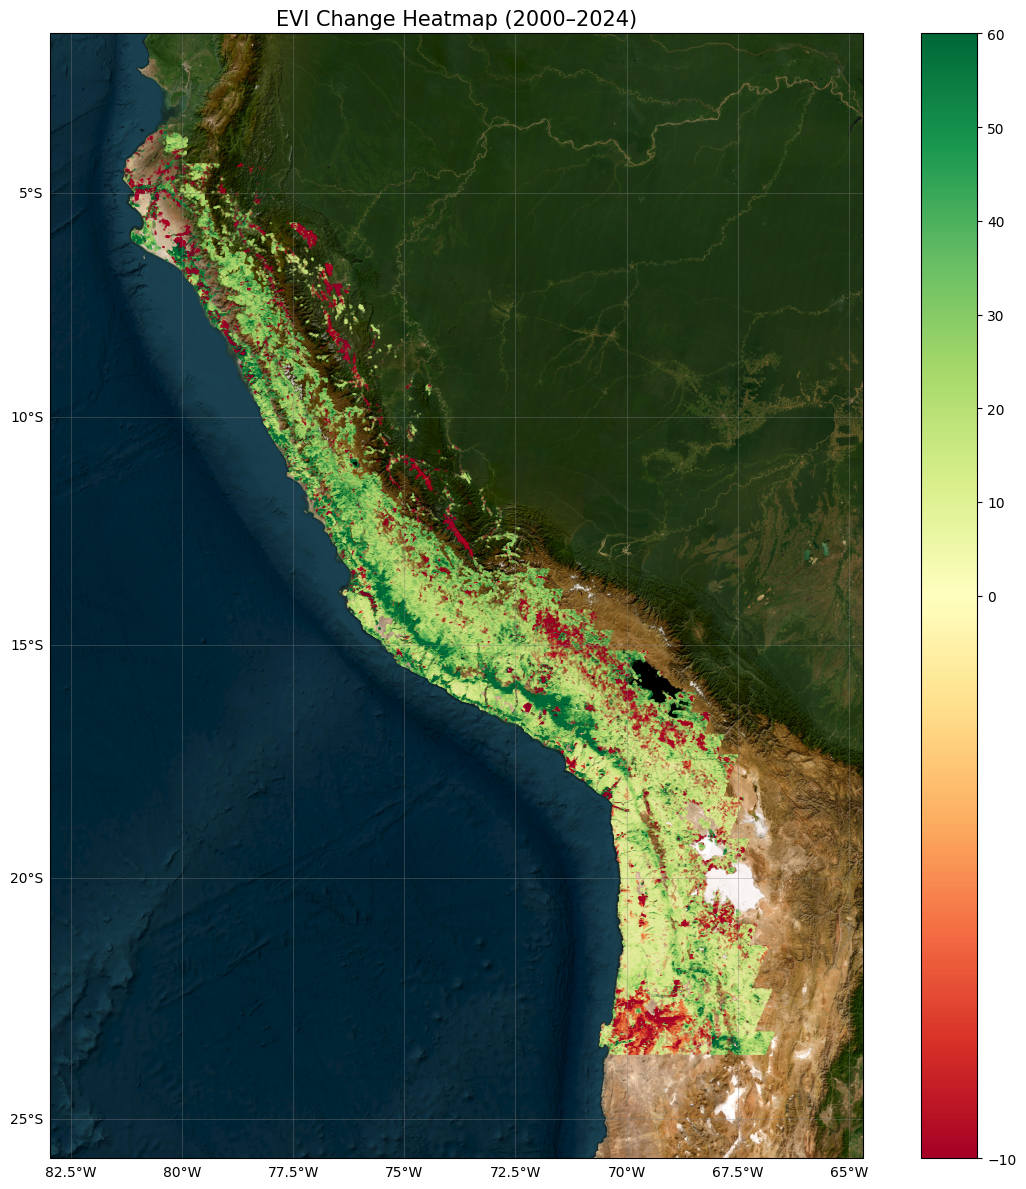

In [ ]:
gdf = gpd.GeoDataFrame(all_features, crs="EPSG:4326")
gdf["delta_evi"] = gdf["delta_evi"].clip(lower=-10, upper=60) # clip to a change of between -10 and +60

class EsriTiles(OSM): # Define a custom tiler class for basemap imagery
    """
    Custom tile provider class for fetching Esri World Imagery basemap tiles.

    Inherits from `OSM` to utilise the standard tile fetching interface but overrides
    the tile URL template to use Esri's World Imagery tile service.

    Methods:
        _image_url(tile):
            Constructs the URL to retrieve a specific tile from the Esri World Imagery service.
    """
    def __init__(self):
        super().__init__()

    def _image_url(self, tile):
        x, y, z = tile
        return (
            f"https://server.arcgisonline.com/ArcGIS/rest/services/"
            f"World_Imagery/MapServer/tile/{z}/{y}/{x}"
        )

tiler = EsriTiles() # create the tiler
mercator = tiler.crs # set the projection

# Setup plot
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={"projection": mercator})
ax.add_image(tiler, 8)

# Plot points 
norm = TwoSlopeNorm(vmin=-10, vcenter=0, vmax=60)
gdf.to_crs(mercator).plot(
    column="delta_evi",
    cmap="RdYlGn",
    norm=norm,
    markersize=0.1,
    alpha=0.1, 
    ax=ax,
    legend=True
)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

ax.set_title("EVI Change Heatmap (2000–2024)", fontsize=15)
plt.tight_layout()
plt.show()

Now export as a GeoTIFF for visualisation in Google Earth Pro

In [ ]:
# remake the GeoDataFrame
gdf = gpd.GeoDataFrame(all_features, crs="EPSG:4326") 

gdf["delta_evi"] = gdf["delta_evi"].clip(lower=-10, upper=60) # clip delta evi range as before

# set pixel size in degrees (0.00225 deg is approx 250 m near the equator)
pixel_size_deg = 0.00225

# Get region bounds
minx, miny, maxx, maxy = gdf.total_bounds
width = int((maxx - minx) / pixel_size_deg)
height = int((maxy - miny) / pixel_size_deg)

# Define transform for EPSG:4326
transform = from_origin(minx, maxy, pixel_size_deg, pixel_size_deg)

# Rasterise delta evi values
shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf["delta_evi"]))
evi_raster = rasterize(
    shapes=shapes,
    out_shape=(height, width),
    transform=transform,
    fill=np.nan,
    dtype="float32",
    all_touched=True
)

norm = TwoSlopeNorm(vmin=-10, vcenter=0, vmax=60) # normalise to the -10 - 60 range
cmap = cm.get_cmap("RdYlGn") # custom colourbar to have 0 in the middle and -10 and 60 as the limits
rgba_img = cmap(norm(evi_raster))
rgb_img = (rgba_img[:, :, :3] * 255).astype(np.uint8)

# Extract RGB bands from the image
r, g, b = rgb_img[:, :, 0], rgb_img[:, :, 1], rgb_img[:, :, 2]

# Save RGB GeoTIFF in EPSG:4326
output_rgb_tif = geo_tiff_data+"/delta_evi_heatmap_geotiff.tif"
with rasterio.open(
    output_rgb_tif,
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=3,
    dtype="uint8",
    crs="EPSG:4326",  # For Google Earth Pro
    transform=transform
) as dst:
    dst.write(r, 1)
    dst.write(g, 2)
    dst.write(b, 3)

print(f"RGB GeoTIFF (EPSG:4326) saved to: {output_rgb_tif}")